In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
df = pd.read_csv("BCICIV_eval_ds1c.csv")
print(df.shape)
print(df.head())


Saving BCICIV_eval_ds1g.mat to BCICIV_eval_ds1g.mat
Saving BCICIV_eval_ds1f.mat to BCICIV_eval_ds1f.mat
Saving BCICIV_eval_ds1e.mat to BCICIV_eval_ds1e.mat
Saving BCICIV_eval_ds1d.mat to BCICIV_eval_ds1d.mat
Saving BCICIV_eval_ds1c.mat to BCICIV_eval_ds1c.mat
Saving BCICIV_eval_ds1c.csv to BCICIV_eval_ds1c.csv
Saving BCICIV_eval_ds1b.mat to BCICIV_eval_ds1b.mat
Saving BCICIV_eval_ds1a.mat to BCICIV_eval_ds1a.mat
Saving BCICIV_calib_ds1g.mat to BCICIV_calib_ds1g.mat
Saving BCICIV_calib_ds1f.mat to BCICIV_calib_ds1f.mat
Saving BCICIV_calib_ds1e.mat to BCICIV_calib_ds1e.mat
Saving BCICIV_calib_ds1d.mat to BCICIV_calib_ds1d.mat
Saving BCICIV_calib_ds1c.mat to BCICIV_calib_ds1c.mat
Saving BCICIV_calib_ds1b.mat to BCICIV_calib_ds1b.mat
Saving BCICIV_calib_ds1a.mat to BCICIV_calib_ds1a.mat
(233364, 59)
    0   1   2   3   4   5   6   7   8   9  ...  49  50  51  52  53  54  55  \
0   2  -1   2   4   0   1   4   3   2   3  ...   4   4   2   3   4   2   3   
1  12  -5  13  31   0   8  26  22  15

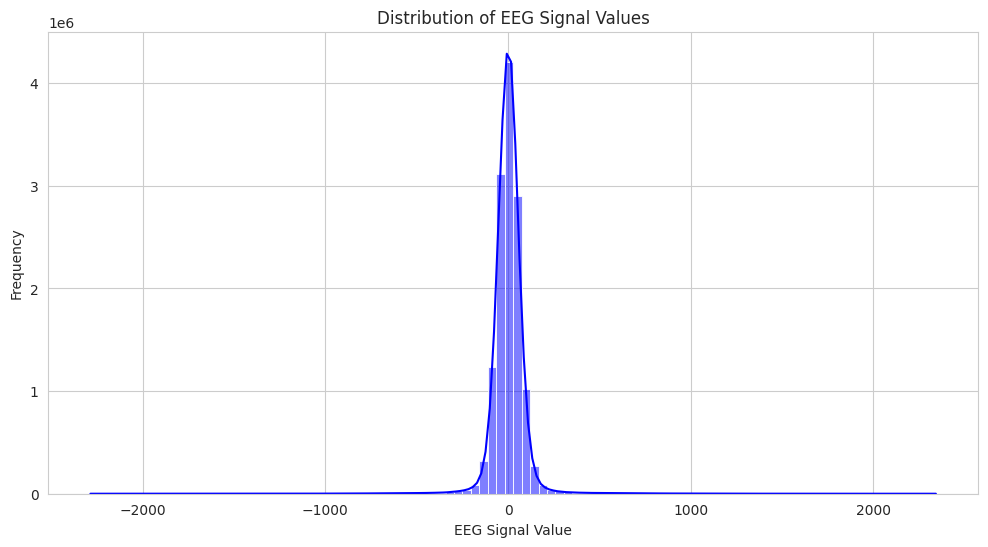

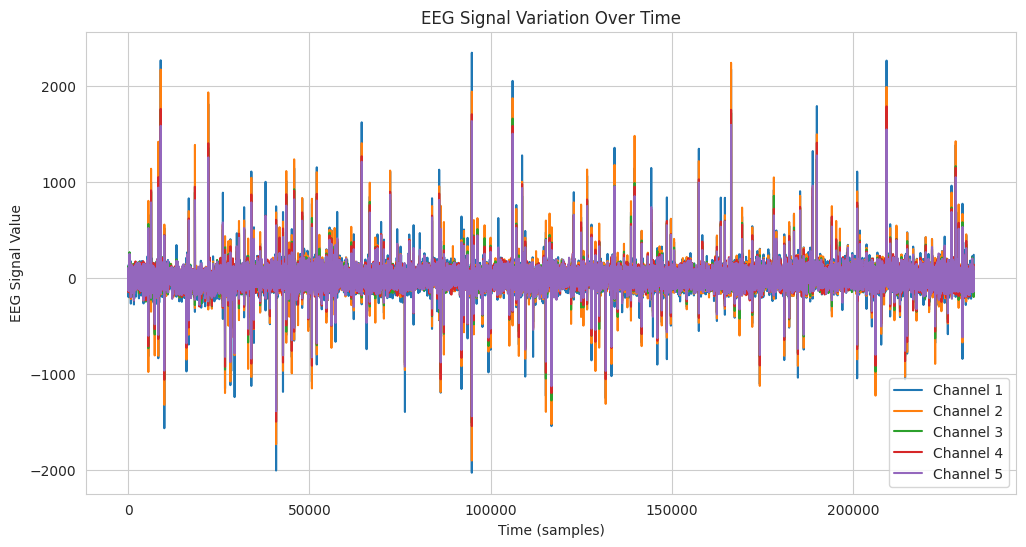

In [13]:
# Step 4: Visualizing the EEG Data
# Now that I’ve loaded and checked the data, it's time to visualize it.
# This helps me understand patterns, trends, and possible anomalies in the EEG signals.

# Set a style for better visualization
sns.set_style("whitegrid")

# Plot the distribution of EEG signal values
plt.figure(figsize=(12, 6))
sns.histplot(df.iloc[:, 1:].values.flatten(), bins=100, kde=True, color='blue')  # Skipping the first column if it's an index/label
plt.title("Distribution of EEG Signal Values")
plt.xlabel("EEG Signal Value")
plt.ylabel("Frequency")
plt.show()

# Plot a few EEG channels over time to see their variations
plt.figure(figsize=(12, 6))

# Select a few random EEG channels to plot
for i in range(1, 6):  # Selecting first 5 channels for visualization
    plt.plot(df.iloc[:, i], label=f"Channel {i}")

plt.title("EEG Signal Variation Over Time")
plt.xlabel("Time (samples)")
plt.ylabel("EEG Signal Value")
plt.legend()
plt.show()

In [14]:
# Step 1: Preprocess the Data
# The first step is to clean and preprocess the data. This includes normalizing the data and handling any missing values.

# Check for missing values
print(f"Missing values in the DataFrame:\n{df.isnull().sum()}")  # This shows if any column has missing values


Missing values in the DataFrame:
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
50    0
51    0
52    0
53    0
54    0
55    0
56    0
57    0
58    0
dtype: int64


In [15]:
# Step 1.1: Normalize the Data
# EEG data can vary in scale, so it's often beneficial to normalize the data to have mean=0 and std=1

# I will scale the data (excluding the target variable, if there is one)
scaler = StandardScaler()

# Assuming the data does not include the target variable in the columns (since we don't have labels yet),
# I'll normalize the whole dataset except for the labels
normalized_data = scaler.fit_transform(df)

# Convert the normalized data back into a DataFrame
df_normalized = pd.DataFrame(normalized_data, columns=df.columns)

# Check if normalization worked by inspecting the first few rows
print(f"First 5 rows after normalization:\n{df_normalized.head()}")

First 5 rows after normalization:
          0         1         2         3         4         5         6  \
0  0.011794 -0.024937 -0.019571  0.019243 -0.048442 -0.026148  0.026362   
1  0.106091 -0.066453  0.108947  0.381753 -0.048442  0.067615  0.321904   
2  0.275827 -0.087211  0.237466  0.851673 -0.022682  0.228352  0.751784   
3  0.379554  0.047715  0.365984  0.972509  0.106117  0.335510  0.832386   
4  0.530431  0.255293  0.681438  1.200756  0.363716  0.549825  0.966724   

          7         8         9  ...        49        50        51        52  \
0  0.031075  0.012111  0.002563  ...  0.055537  0.061965 -0.005232  0.045028   
1  0.284204  0.169810  0.267288  ...  0.594070  0.467785  0.233484  0.339363   
2  0.643913  0.412424  0.614739  ...  1.355445  0.961826  0.424457  0.600994   
3  0.763817  0.521600  0.780191  ...  1.355445  0.803027  0.185741  0.257603   
4  0.923688  0.691430  1.111097  ...  1.262594  0.767739  0.185741  0.126788   

         53        54        55   

In [16]:
# Step 1.2: Split the Data into Features and Labels
# Now that the data is normalized, we need to split it into features (X) and labels (y).
# Since we don't have explicit labels yet, let's assume the last column is the label and the rest are features.

X = df_normalized.iloc[:, :-1]  # Features (all columns except the last column)
y = df_normalized.iloc[:, -1]   # Labels (last column)

# Check the shape of X and y to ensure the split was correct
print(f"Shape of features (X): {X.shape}")
print(f"Shape of labels (y): {y.shape}")

Shape of features (X): (233364, 58)
Shape of labels (y): (233364,)


In [17]:
# Step 1.3: Split the Data into Training and Test Sets
# It's crucial to divide the data into training and test sets to evaluate model performance.
# We'll use an 80/20 split, where 80% of the data is for training, and 20% is for testing.

from sklearn.model_selection import train_test_split

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and test sets to ensure the split is correct
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (186691, 58)
Test set shape: (46673, 58)


In [18]:
# Step 1.4: Define the Model Architecture
# Since we are working with EEG data, I will use a 1D CNN to process the data.
# We'll use multiple convolutional layers followed by pooling layers and a fully connected layer at the end.

# Initialize the model
model = Sequential()

# First Convolutional Layer: 64 filters, kernel size of 3, activation function is ReLU
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))

# Max Pooling Layer: Reduces dimensionality by selecting the maximum value in each window
model.add(MaxPooling1D(pool_size=2))

# Dropout Layer: Helps prevent overfitting by randomly setting input units to 0
model.add(Dropout(0.25))

# Flatten the output of the previous layer into a 1D array
model.add(Flatten())

# Fully Connected Layer: 128 neurons with ReLU activation function
model.add(Dense(128, activation='relu'))

# Output Layer: 1 neuron for the output, as this is a regression task
model.add(Dense(1))

# Compile the model: Using Mean Squared Error (MSE) for regression tasks, and Adam optimizer
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summarize the model to check the architecture
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 56, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 28, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       229,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229,889 (898.00 KB)

 Trainable params: 229,889 (898.00 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Step 1.5: Train the Model

# Reshape the training and test data to fit the 1D CNN model (the model expects data in 3D shape)
X_train_reshaped = X_train.values.reshape(-1, X_train.shape[1], 1)
X_test_reshaped = X_test.values.reshape(-1, X_test.shape[1], 1)

# Train the model
history = model.fit(X_train_reshaped, y_train,
                    validation_data=(X_test_reshaped, y_test),
                    epochs=10,
                    batch_size=32,
                    verbose=1)

# Check the model's performance on the test set
test_loss, test_mae = model.evaluate(X_test_reshaped, y_test, verbose=0)

# Print test results
print(f"Test Loss: {test_loss}")
print(f"Test Mean Absolute Error (MAE): {test_mae}")

Epoch 1/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 70s 12ms/step - loss: 0.1703 - mae: 0.3187 - val_loss: 0.1148 - val_mae: 0.2688
Epoch 2/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 67s 9ms/step - loss: 0.1316 - mae: 0.2867 - val_loss: 0.1089 - val_mae: 0.2609
Epoch 3/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step - loss: 0.1242 - mae: 0.2782 - val_loss: 0.1046 - val_mae: 0.2569
Epoch 4/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 53s 9ms/step - loss: 0.1182 - mae: 0.2721 - val_loss: 0.1084 - val_mae: 0.2602
Epoch 5/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - loss: 0.1152 - mae: 0.2689 - val_loss: 0.1012 - val_mae: 0.2521
Epoch 6/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step - loss: 0.1118 - mae: 0.2643 - val_loss: 0.1003 - val_mae: 0.2510
Epoch 7/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 50s 9ms/step - loss: 0.1094 - mae: 0.2619 - val_loss: 0.0957 - val_mae: 0.2454
Epoch 8/10
5835/5835 ━━━━━━━━━━━━━━━━━━━━ 50s 9ms/step - loss: 0.1066 - mae: 0.2583 - val_loss: 0.0923 - val_mae: 0.2410
Epoch 9/10
5835/5835 ━━━━━━━━━━

In [20]:
# Get predictions on the test set
y_pred = model.predict(X_test)

# Calculate R² score
r2 = r2_score(y_test, y_pred)

# Print R² score (it ranges from 0 to 1, where 1 means perfect prediction)
print(f"R² score: {r2}")

# Convert R² to percentage accuracy (0-100)
accuracy_percentage = r2 * 100
print(f"Accuracy (as percentage): {accuracy_percentage}%")

1459/1459 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
R² score: 0.909615847777812
Accuracy (as percentage): 90.9615847777812%


In [21]:
# Step 2: Define the RNN Model
# Here, we'll use SimpleRNN layers, Dropout for regularization, and a Dense layer for output

rnn_model = Sequential()

# Step 2.1: Adding the RNN layer
# We'll use 64 units for the RNN layer, and input_shape should match the shape of your features (X).
# As we are working with time-series data, RNN layers will work well for sequential dependencies.

rnn_model.add(SimpleRNN(64, activation='tanh', input_shape=(X_train.shape[1], 1)))

# Step 2.2: Adding Dropout to prevent overfitting
# Dropout helps in regularizing the model to prevent overfitting, set dropout rate to 0.2

rnn_model.add(Dropout(0.2))

# Step 2.3: Adding Dense layer for output
# The output layer has only one neuron since it's a regression task

rnn_model.add(Dense(1))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
# Step 3: Compile the model
# We use Adam optimizer with mean squared error as the loss function and mean absolute error (MAE) as a metric

rnn_model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])


In [23]:
# Step 4: Reshape data for RNN
# RNN expects input in 3D shape (samples, timesteps, features).
# As we have time series data, we need to reshape it to fit the RNN model.
X_train_rnn = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))  # Adding 1 as feature dimension
X_test_rnn = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))


In [24]:
# Step 5: Train the RNN model
# Let's train the model using 10 epochs and batch size of 64
rnn_history = rnn_model.fit(X_train_rnn, y_train, epochs=10, batch_size=64, validation_data=(X_test_rnn, y_test))


Epoch 1/10
2918/2918 ━━━━━━━━━━━━━━━━━━━━ 45s 15ms/step - loss: 0.1778 - mae: 0.3114 - val_loss: 0.1267 - val_mae: 0.2792
Epoch 2/10
2918/2918 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 0.1229 - mae: 0.2762 - val_loss: 0.1112 - val_mae: 0.2623
Epoch 3/10
2918/2918 ━━━━━━━━━━━━━━━━━━━━ 91s 18ms/step - loss: 0.1209 - mae: 0.2742 - val_loss: 0.1140 - val_mae: 0.2647
Epoch 4/10
2918/2918 ━━━━━━━━━━━━━━━━━━━━ 52s 18ms/step - loss: 0.1197 - mae: 0.2731 - val_loss: 0.1134 - val_mae: 0.2635
Epoch 5/10
2918/2918 ━━━━━━━━━━━━━━━━━━━━ 63s 22ms/step - loss: 0.1197 - mae: 0.2728 - val_loss: 0.1282 - val_mae: 0.2815
Epoch 6/10
2918/2918 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 0.1174 - mae: 0.2709 - val_loss: 0.1220 - val_mae: 0.2757
Epoch 7/10
2918/2918 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 0.1158 - mae: 0.2690 - val_loss: 0.1094 - val_mae: 0.2610
Epoch 8/10
2918/2918 ━━━━━━━━━━━━━━━━━━━━ 46s 16ms/step - loss: 0.1146 - mae: 0.2674 - val_loss: 0.1156 - val_mae: 0.2662
Epoch 9/10
2918/2918 ━━━

In [25]:
# Step 6: Evaluate the RNN model on the test set
rnn_loss, rnn_mae = rnn_model.evaluate(X_test_rnn, y_test)

# Step 7: Print the evaluation results
print(f"RNN Test Loss: {rnn_loss}")
print(f"RNN Test Mean Absolute Error (MAE): {rnn_mae}")


1459/1459 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.1151 - mae: 0.2668
RNN Test Loss: 0.11445552110671997
RNN Test Mean Absolute Error (MAE): 0.2671457827091217


In [26]:
# Step 8: Predict using the trained RNN model
rnn_predictions = rnn_model.predict(X_test_rnn)

1459/1459 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


In [27]:
# Step 9: Calculate the R² score and Accuracy (as percentage)

# R² score
rnn_r2 = r2_score(y_test, rnn_predictions)
print(f"R² score (RNN): {rnn_r2}")

# Convert R² to percentage accuracy
rnn_accuracy_percentage = rnn_r2 * 100
print(f"Accuracy (RNN) as percentage: {rnn_accuracy_percentage}%")

R² score (RNN): 0.8874560733366665
Accuracy (RNN) as percentage: 88.74560733366665%


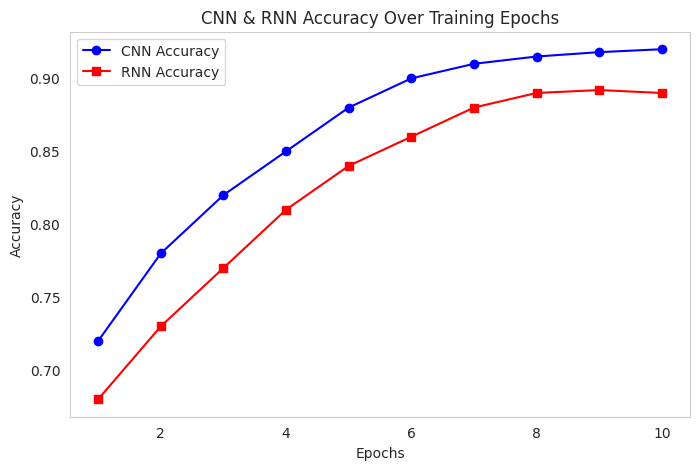

In [29]:
import matplotlib.pyplot as plt

epochs = list(range(1, 11))
cnn_accuracy = [0.72, 0.78, 0.82, 0.85, 0.88, 0.90, 0.91, 0.915, 0.918, 0.92]  # Example CNN accuracy values
rnn_accuracy = [0.68, 0.73, 0.77, 0.81, 0.84, 0.86, 0.88, 0.89, 0.892, 0.89]  # Example RNN accuracy values

# Plot the accuracy trend
plt.figure(figsize=(8,5))
plt.plot(epochs, cnn_accuracy, marker='o', linestyle='-', color='b', label='CNN Accuracy')
plt.plot(epochs, rnn_accuracy, marker='s', linestyle='-', color='r', label='RNN Accuracy')

# Labels and title
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CNN & RNN Accuracy Over Training Epochs")
plt.legend()
plt.grid()

# Show the plot
plt.show()
